# NLO Finite top samples

**Goal:** Compare with the baseline analysis using the *background estimate* that Sean trained and the NLO samples that Marco processed.

In [19]:
import pandas as pd
import numpy as np
import itertools
from itertools import combinations
from tqdm import tqdm
from glob import glob

import matplotlib.pyplot as plt
from matplotlib import gridspec

import json
import time
import h5py
import uproot
import torch

from trainNet import pairAGraph
from preprocess import truthInfo, parallelTruthMatchJets, parallelGetCorrectPair
from preprocess import processDf, scale, applyCuts

import os
os.sys.path.append('../code')
from analysis import fileDir, normalizeWeight
from AnalysisUtils import nanoToDf
from eventDisplays import truthDisplay

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Load in the samples that Marco processed with the BDT pairing**

In [30]:
fDir = "../../public/hh4b/nanoNtuples/marcoJUN20/600043_mc16d/" 
sdf_bdt = nanoToDf(f"{fDir}/NanoNTuple.root",ttree="sig")

# Doing the luminosity normalization here as well
lumi16 = 24.5556
sdf_bdt['mc_sf'] *= lumi16

sig


In [27]:
SeanDir = "../../public/hh4b/nanoNtuples/NNT_MAY20-1/" 

rr = uproot.open(f"{SeanDir}/data16_NN_100_bootstraps_IQR.root")
bdf_bdt = rr["fullmassplane"].pandas.df()
bdf_bdt['NN_d24_weight_bstrap_med_16'] *= rr['NN_norm_bstrap_med_16']._fVal
bdf_bdt['NN_d24_weight_VRderiv_bstrap_med_16'] *= rr['NN_norm_VRderiv_bstrap_med_16']._fVal

In [25]:
edges = np.array([150, 250, 262, 275, 288, 302, 317, 332, 348, 365, 383, 402, 422, 443, 465, 488, 512, 
                  537, 563, 591, 620, 651, 683, 717, 752, 789, 828, 869, 912, 957,1004, 1054, 1106, 1161, 
                  1219, 1279, 1342, 1409, 1479, 1552, 1629, 1710, 1795, 1884, 1978, 2076])

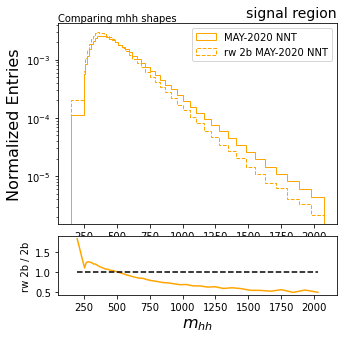

In [31]:
fig = plt.figure(figsize=(5, 5))
gs = gridspec.GridSpec(4,1)
ax1 = fig.add_subplot(gs[:3,0])
ax2 = fig.add_subplot(gs[3:,0],sharex=ax1)

# BDT pairing
ba,e,_ = ax1.hist(bdf_bdt['m_hh'],
                   edges,color='orange',histtype='step',log=True,
                   label="MAY-2020 NNT",ls='-',density=True)

bb,_,_ = ax1.hist(bdf_bdt['m_hh'],
                   edges,color='orange',histtype='step',log=True,
                   label="rw 2b MAY-2020 NNT",ls='--',
                   weights=bdf_bdt['NN_d24_weight_bstrap_med_16'],density=True)

xx = 0.5 * (e[1:]+e[:-1])
ax2.plot(xx,bb/ba,'orange')
ax2.plot(xx, np.ones_like(xx),'k--')

ax1.set_ylabel('Normalized Entries',fontsize=16)
ax1.text(0,1,'Comparing mhh shapes',ha='left',va='bottom',transform=ax1.transAxes)
ax1.legend(fontsize=10)#,bbox_to_anchor=(1,1.05))
ax1.set_title('signal region', loc='right',fontsize=14)
ax2.set_ylabel('rw 2b / 2b')
ax2.set_xlabel('$m_{hh}$',fontsize=16)

#plt.savefig(f'figures/{subDir}/m_hh_SR_log_ratio_cf_baseline_2bCRscaled.pdf',bbox_inches='tight')
plt.show()

**Evaluate the massplanes and $m_{hh}$ for the NLO FT samples**

In [5]:
pconfig = 'NLO_FT'
filename_2b = f'../data/data16_PFlow-FEB20-5jets/df_{pconfig}_2b.h5'
filename_3b = f'../data/data16_PFlow-FEB20-5jets/df_{pconfig}_3b.h5'

print('loading in the = 2b df')
dat_sm_2b = pd.read_hdf(filename_2b,key='df')

print('loading in the >= 3b df')
dat_sm_3b = pd.read_hdf(filename_3b,key='df')

loading in the >= 3b df
loading in the = 2b df


In [8]:
for df in [dat_sm_2b, dat_sm_3b]:
    df['abs_deta_hh'] = np.abs(df.eta_h1 - df.eta_h2)

**Process the SM**

**Question:** How does training on $\kappa_\lambda$ = 10 impact the SM efficiency?

In [13]:
prodTag = 'APR2020'
nSelectedJets = 5

In [15]:
pconfig = 'NLO_FT'
with open(f"configs/{pconfig}.json", 'r') as varfile:
    GNNParams = json.load(varfile)
nLayers, embed_dim, ff_dim = GNNParams['nLayers'], GNNParams['embed_dim'], GNNParams['ff_dim']
nHeads, dpt, lr, epoch = GNNParams['nHeads'], GNNParams['dpt'], GNNParams['lr'], GNNParams['epoch']
trainTag = GNNParams['trainingEvents']
physicsSample,mc,trainingEvents = GNNParams['physicsSample'],GNNParams['mc'],GNNParams['trainingEvents']

xformerDir = f'xformer_{nLayers}layers_dim{embed_dim}_ff{ff_dim}_{nHeads}heads_dpt{dpt}_jetCompatibility_lr{lr}_batch2048_{trainTag}_mask'
modelDir1 = f"models/{physicsSample}_{mc}_PFlow-{prodTag}-{nSelectedJets}jets/{xformerDir}_wcut_1.0_2b"

In [20]:
smDir = f'SMNR_mc16a_PFlow-{prodTag}-{nSelectedJets}jets'
sm_smPair  = pd.read_hdf(f"../data/{smDir}/df_2b_scaledInputs.h5", key='df')

# model trained w/ SM sample
m_SM = pairAGraph(inpt_dim=5,embed_dim=embed_dim,ff_dim=ff_dim,
                  nAttnBlocks=1,nHeads=nHeads,p=dpt,njets=nSelectedJets)
m_SM.load_state_dict(torch.load(f'{modelDir1}/model.pt',map_location='cpu'))
m_SM.eval()

# pairing
applyCuts(sm_smPair, m_SM,nSelectedJets)

# Normalize mc sf
normalizeWeight(sm_smPair, smDir[:-6],lumi=lumi16)

max(njets) 5
Getting jet pts
Getting jet etas
Getting jet phis
Getting jet Es
Calculating Xwt
Calculating Xhh
/gpfs/slac/atlas/fs1/d/nhartman/public/hh4b/kappa_lambda/user.valentem.HH4B.600043.HH_NLO.MC16a-2015-2016.AB21.2.91-APR20-1.full_MiniNTuple.root/user.valentem.21562918._000001.MiniNTuple.root
sum_weights_initial 26760.097015455365
xsec 27.47
k_factor 1.13
gen_filter_eff 0.3392
sample_weight 0.009661750386665119


In [23]:
sm_smPair['abs_deta_hh'] = np.abs(sm_smPair['eta_h1'] - sm_smPair['eta_h2'])

In [34]:
np.max(bdf_bdt.loc[bmask1,'ntag'])

2

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


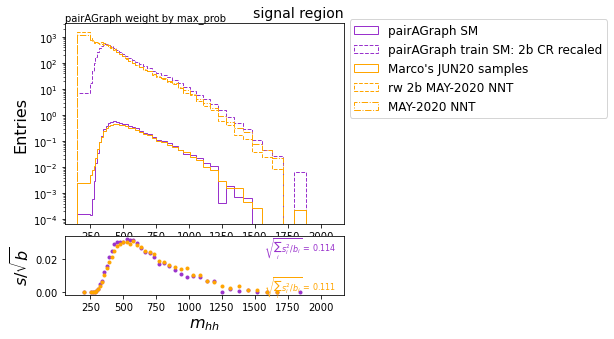

In [47]:
fig = plt.figure(figsize=(5, 5))
gs = gridspec.GridSpec(4,1)
ax1 = fig.add_subplot(gs[:3,0])
ax2 = fig.add_subplot(gs[3:,0],sharex=ax1)

# SM NLO training
smask0 = (sm_smPair.ntag>=4) & (sm_smPair.trigger) & (sm_smPair.abs_deta_hh < 1.5) & (sm_smPair.X_wt > 1.5) & (sm_smPair.kinematic_region == 0)
s0,_,_ = ax1.hist(sm_smPair.loc[smask0,'m_hh'],edges,
                  label='pairAGraph SM',
                  weights=sm_smPair.loc[smask0,'mc_sf']*sm_smPair.loc[smask0,'max_prob'],
                  color='darkorchid',histtype='step',log=True)

N2b = np.sum((dat_sm_2b.kinematic_region==2) & (dat_sm_2b.abs_deta_hh < 1.5) & (dat_sm_2b.X_wt > 1.5))
N4b = np.sum((dat_sm_3b.ntag>=4) & (dat_sm_3b.kinematic_region==2) & (dat_sm_3b.abs_deta_hh < 1.5) & (dat_sm_3b.X_wt > 1.5))
N0 = N4b/N2b

SR_2b0 = (dat_sm_2b.kinematic_region==0) & (dat_sm_2b.abs_deta_hh < 1.5) & (dat_sm_2b.X_wt > 1.5)
b0,_,_ = ax1.hist(dat_sm_2b.loc[SR_2b0,'m_hh'],edges,
                  label='pairAGraph train SM: 2b CR recaled',
                  weights=N0*dat_sm_2b.loc[SR_2b0,'max_prob'],log=True,
                  color='darkorchid',histtype='step',linestyle='--')


# BDT pairing
smask1 = (sdf_bdt.ntag>=4) & (sdf_bdt.kinematic_region == 0)
s1,_,_ = ax1.hist(sdf_bdt.loc[smask1,'m_hh'],edges,
                  label='Marco\'s JUN20 samples',
                  weights=sdf_bdt.loc[smask1,'mc_sf'],
                  color='orange',histtype='step',log=True)

b1b,_,_ = ax1.hist(bdf_bdt.loc[bmask1,'m_hh'],
                   edges,color='orange',histtype='step',log=True,
                   label="rw 2b MAY-2020 NNT",ls='--',
                   weights=bdf_bdt.loc[bmask1,'NN_d24_weight_bstrap_med_16'])

N2b = np.sum(bmask1)
b1a,_,_ = ax1.hist(bdf_bdt.loc[bmask1,'m_hh'],
                   edges,color='orange',histtype='step',log=True,
                   label="MAY-2020 NNT",ls='-.',
                   weights = np.sum(b1b) / N2b * np.ones(N2b))

ax2.plot(xx, s0/np.sqrt(b0),marker='.',color='darkorchid',   linewidth=0)
ax2.plot(xx, s1/np.sqrt(b1b),marker='.',color='orange',linewidth=0)
ax2.set_xlabel('$m_{hh}$',fontsize=16)
#ax2.set_ylim(0,.04)

_,ymax = ax1.get_ylim()
ax1.set_ylim(0,ymax)

ax1.set_ylabel('Entries',fontsize=16)
ax1.text(0,1,'pairAGraph weight by max_prob',ha='left',va='bottom',transform=ax1.transAxes)

sigText = '$\sqrt{\sum_i{s_i^2 / b_i}}$ = '

ax2.text(.975,1,
         sigText+'{:.3f}'.format(np.sqrt(np.sum(s0[b0!=0]**2 / b0[b0!=0]))),
         ha='right',va='top',transform=ax2.transAxes,color='darkorchid',fontsize=8)
ax2.text(.975,.35,
         sigText+'{:.3f}'.format(np.sqrt(np.sum(s1[b1b!=0]**2 / b1b[b1b!=0]))),
         ha='right',va='top',transform=ax2.transAxes,color='orange',fontsize=8)


ax2.set_ylabel('$s / \sqrt{b}$',fontsize=16)
ax1.legend(fontsize=12,bbox_to_anchor=(1,1.05))
ax1.set_title('signal region', loc='right',fontsize=14)

#plt.savefig(f'figures/{subDir}/m_hh_SR_log_ratio_cf_baseline_2bCRscaled.pdf',bbox_inches='tight')

plt.show()

- I still have MDR and MDpT cuts in my backpocket too...
- *And* adjusting the SR!

Ok - I'm going to say this is a *promising* step!!

In [45]:
np.sum(b1b)

9488.040314006816

In [44]:
np.sum(b1a)

91.2327489506358

**Reweight**

In [55]:
dat_sm_2b['dPhi_hh'] = np.arccos(np.cos(dat_sm_2b.phi_h1 - dat_sm_2b.phi_h2))
dat_sm_2b['dR_hh'] = np.sqrt( dat_sm_2b['dPhi_hh']**2 + (dat_sm_2b.eta_h1 - dat_sm_2b.eta_h2)**2 )

rw_cols=['pT_4', 'pT_2','eta_i', 'dRjj_1', 'dRjj_2', 
         'njets', 'pt_hh', 'X_wt', 'dPhi_hh', 'dR_hh']

In [50]:
os.sys.path.append('../eda_tools')
from NN_RW import getNNweights

Using TensorFlow backend.
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be u

In [58]:
dat_sm_2b[rw_cols].astype('float32')

MemoryError: Unable to allocate 13.9 GiB for an array with shape (33, 56437409) and data type float64

In [56]:
dat_sm = pd.concat([dat_sm_2b[rw_cols].astype('float32'), 
                    dat_sm_3b[rw_cols].astype('float32')])

MemoryError: Unable to allocate 13.9 GiB for an array with shape (33, 56437409) and data type float64

In [54]:
dat_sm_3b.columns

KeyboardInterrupt: 

In [ ]:
nHidden = 50 

modelName = f"../rw_models/data16_pairAGraph_tr_SMNR_2b/FEB20_rw_dPhi_dR_hh_nHidden_{nHidden}.h5"

mask = (dat_sm_2b.abs_deta_hh < 1.5) & (dat_sm_2b.X_wt > 1.5)

getNNweights(dat_mdr, mask=mask, kinematic_region=2,
             sort_rw_cols=sort_rw_cols, nHidden=nHidden,
             epochs = 80, patience=10, train=False, 
             key=f"w_2b_pT_{pT}_nHidden_{nHidden}", 
             modelName=modelName)

# Load the min val loss
historyName = modelName[:-3]+"_history.h5"

h = h5py.File(historyName,"r")

vl = np.min(h['val_loss'][:])
min_val_loss[key].append(vl)

h.close()
